You can check [here](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md) to get needed environment, but you don't need to worry it in colab.

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 25kB/s 
     |████████████████████████████████| 6.6MB 49.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=4e04a6bd1a98edb38d83ac9bf4c292b1058d19311632ace84fe6060dfce06bc0
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip

In [2]:
!git clone https://github.com/tangsanli5201/DeepPCB
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 35.87 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 4.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201122-cp36-none-any.whl size=44456 sha256=1bab1f636c93353ccaf0331428af53256c492f2644f745cd264b8638732733ed
  Stored in directory: /root/.cache/pip/wheels/33/7b/ec/59dffd0a0aa995739aad60ac97e70252247e9d17eae69c1cee
Successfully built fvcore


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

We have to take the data out from the .txt file.

In [5]:
import csv
train, test = [],[]
def take_path(x,d):
    with open(d) as t:
        #print(t.read())
        #print(type(csv.reader(t)))
        tmp = csv.reader(t,delimiter=' ')
        for i in tmp:
            x.append(i)
        for ele in x:
            ele[0] = './DeepPCB/PCBData/'+ele[0][:-4]+'_test.jpg'
            ele[1] = './DeepPCB/PCBData/'+ele[1]

take_path(test,'./DeepPCB/PCBData/test.txt')
print(test[:2])
take_path(train,'./DeepPCB/PCBData/trainval.txt')
print(train[:2])


[['./DeepPCB/PCBData/group20085/20085/20085291_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085291.txt'], ['./DeepPCB/PCBData/group20085/20085/20085292_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085292.txt']]
[['./DeepPCB/PCBData/group20085/20085/20085000_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085000.txt'], ['./DeepPCB/PCBData/group20085/20085/20085001_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085001.txt']]


In [6]:
height, width = cv2.imread(test[0][0]).shape[:2]
print(height, width)


640 640


# New Section

In [7]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#DatasetCatalog.clear()
#If you want to clear the data you registered, uncomment the upper line.

def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
            
        objs = []
        with open(path[1]) as t:
            print(path[1])
            lines = t.readlines()
            print(lines)
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')
                print(box)
                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])
                print(boxes)
                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    #you will need this for mask RCNN
                    "category_id": category-1,
                    "iscrowd": 0
                }
                print(obj)
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d,x in [("train",train), ("test",test)]:
    DatasetCatalog.register("PCB_" + d, lambda x=x: get_PCB_dict(x))
    MetadataCatalog.get("PCB_" + d).set(thing_classes=["open", "short", "mousebite", "spur", "copper", "pin-hole"],thing_colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)])
    #I set the colors, but it's no use. Retry after training.
PCB_metadata = MetadataCatalog.get("PCB_train")

In [9]:
#check dataset
print(type(PCB_metadata))

MetadataCatalog.get("PCB_test")

<class 'detectron2.data.catalog.Metadata'>


Metadata(name='PCB_test', thing_classes=['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole'], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)])

Get all the data and check the content inside

In [10]:
dataset_dicts = get_PCB_dict(train)

Streaming output truncated to the last 5000 lines.
['492', '393', '529', '426', '6']
[492.0, 393.0, 529.0, 426.0]
{'bbox': [492.0, 393.0, 529.0, 426.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
['247', '200', '291', '230', '4']
[247.0, 200.0, 291.0, 230.0]
{'bbox': [247.0, 200.0, 291.0, 230.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}
./DeepPCB/PCBData/group77000/77000_not/77000052.txt
['109 443 135 480 1\n', '523 439 574 474 2\n', '180 191 228 234 2\n', '163 267 198 304 4\n', '81 219 124 256 6\n']
['109', '443', '135', '480', '1']
[109.0, 443.0, 135.0, 480.0]
{'bbox': [109.0, 443.0, 135.0, 480.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}
['523', '439', '574', '474', '2']
[523.0, 439.0, 574.0, 474.0]
{'bbox': [523.0, 439.0, 574.0, 474.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}
['180', '191', '228', '234', '2']
[180.0, 191.0, 228.0, 234.0]
{'bbox': [180.0, 191.0, 228.0, 234.0], 

In [11]:
print(dataset_dicts[0])
print(dataset_dicts[1])

{'file_name': './DeepPCB/PCBData/group20085/20085/20085000_test.jpg', 'image_id': 0, 'height': 640, 'width': 640, 'annotations': [{'bbox': [409.0, 394.0, 435.0, 422.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [275.0, 383.0, 319.0, 417.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [8.0, 163.0, 36.0, 191.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}, {'bbox': [244.0, 151.0, 270.0, 182.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}, {'bbox': [338.0, 519.0, 364.0, 543.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}, {'bbox': [476.0, 460.0, 502.0, 481.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}]}
{'file_name': './DeepPCB/PCBData/group20085/20085/20085001_test.jpg', 'image_id': 1, 'height': 640, 'width': 640, 'annotations': [{'bbox': [335.0, 208.0, 364.0, 233.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, '

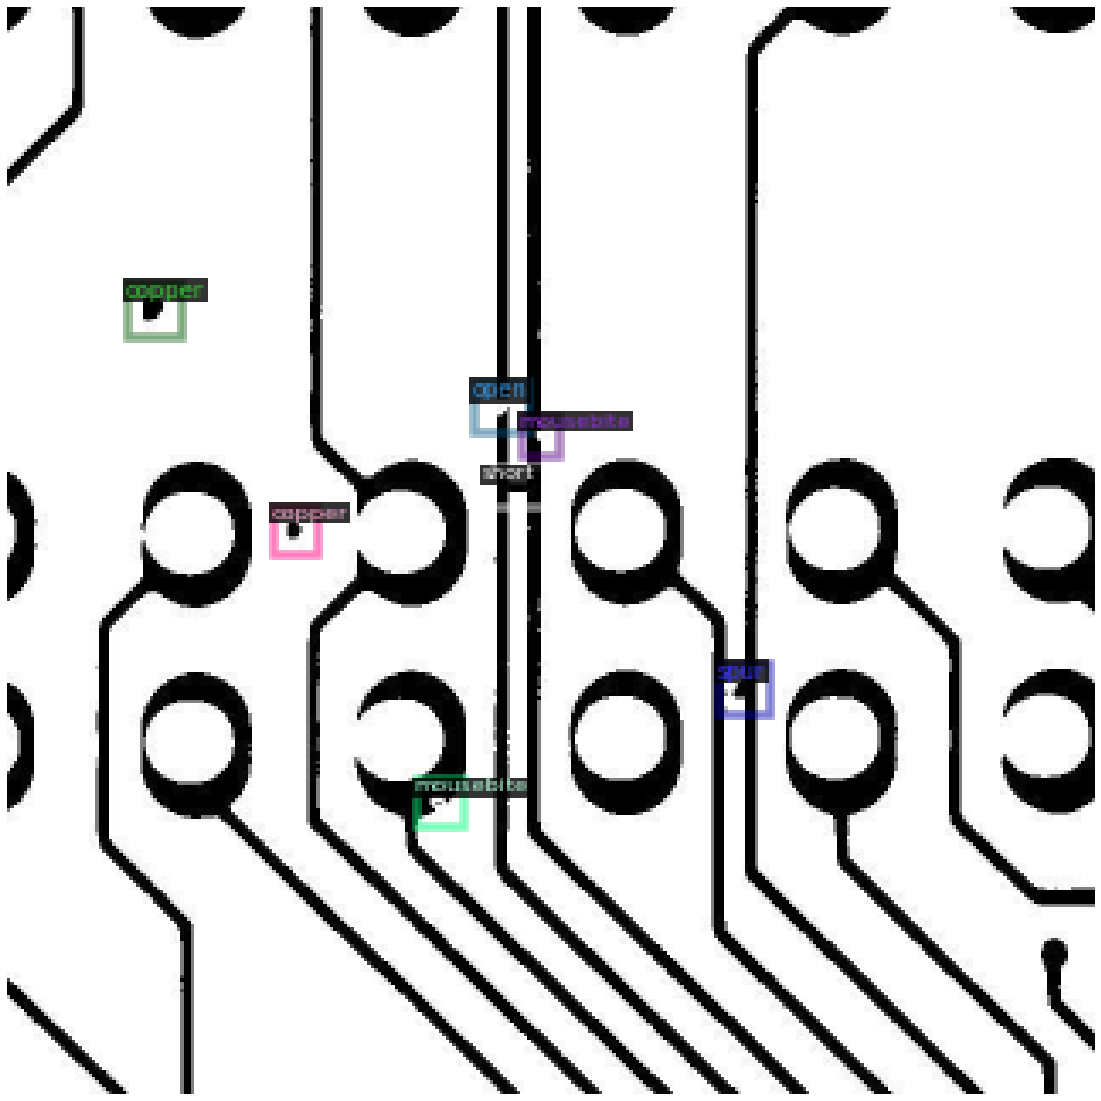

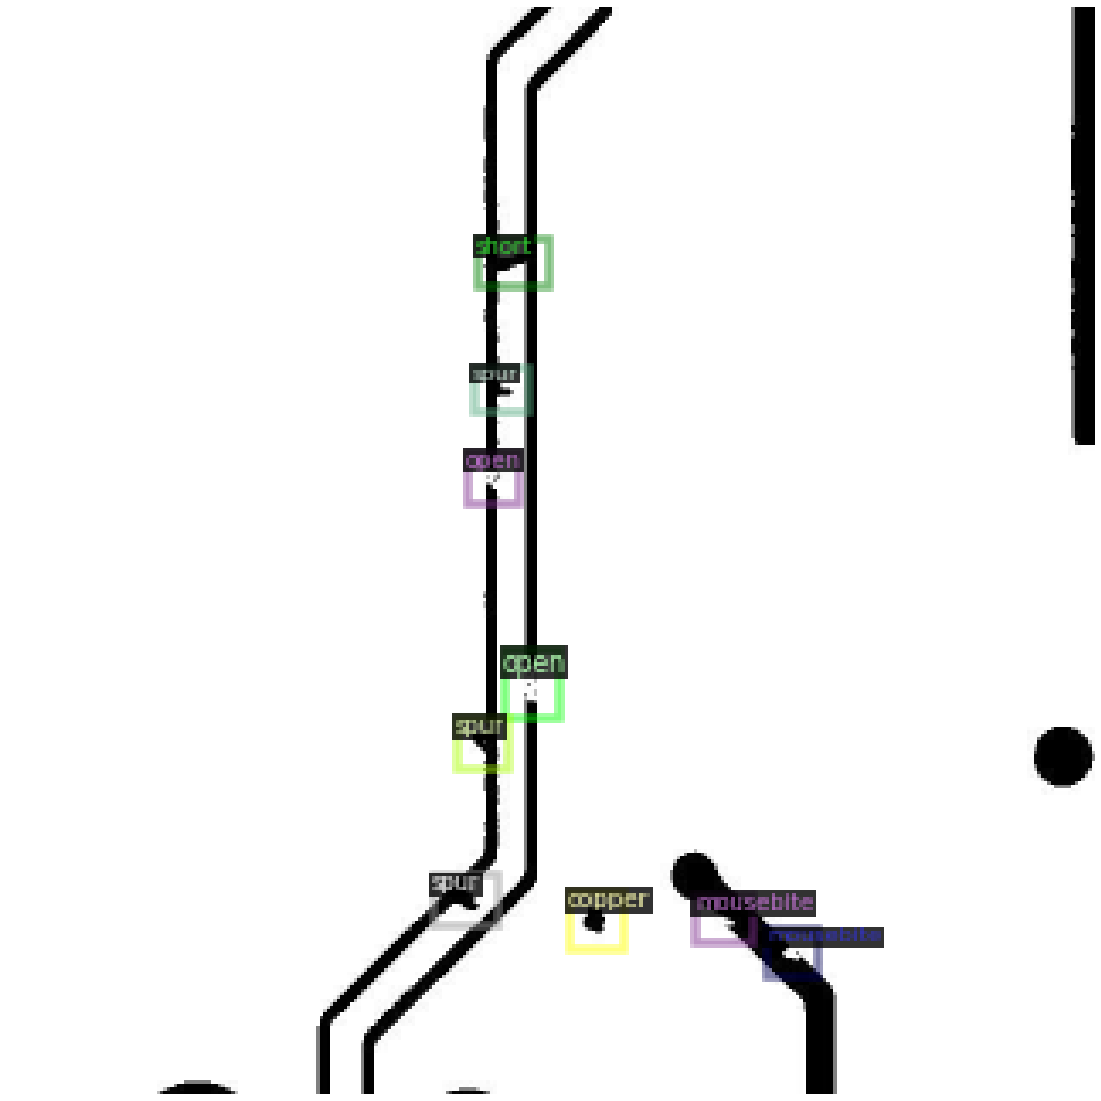

In [12]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PCB_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()
#It will train about 20 minutes in colab.

Streaming output truncated to the last 5000 lines.
[523.0, 439.0, 574.0, 474.0]
{'bbox': [523.0, 439.0, 574.0, 474.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}
['180', '191', '228', '234', '2']
[180.0, 191.0, 228.0, 234.0]
{'bbox': [180.0, 191.0, 228.0, 234.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 1, 'iscrowd': 0}
['163', '267', '198', '304', '4']
[163.0, 267.0, 198.0, 304.0]
{'bbox': [163.0, 267.0, 198.0, 304.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}
['81', '219', '124', '256', '6']
[81.0, 219.0, 124.0, 256.0]
{'bbox': [81.0, 219.0, 124.0, 256.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
./DeepPCB/PCBData/group77000/77000_not/77000053.txt
['213 304 248 347 5\n']
['213', '304', '248', '347', '5']
[213.0, 304.0, 248.0, 347.0]
{'bbox': [213.0, 304.0, 248.0, 347.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}
./DeepPCB/PCBData/group77000/77000_not/77000054.txt
['153 11

model_final_280758.pkl: 167MB [00:02, 75.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.


[11/30 15:01:35 d2.engine.train_loop]: Starting training from iteration 0
[11/30 15:01:41 d2.utils.events]:  eta: 0:00:28  iter: 19  total_loss: 2.594  loss_cls: 1.858  loss_box_reg: 0.030  loss_rpn_cls: 0.565  loss_rpn_loc: 0.158  time: 0.3402  data_time: 0.0390  lr: 0.000005  max_mem: 1829M
[11/30 15:01:49 d2.utils.events]:  eta: 0:00:21  iter: 39  total_loss: 2.227  loss_cls: 1.658  loss_box_reg: 0.032  loss_rpn_cls: 0.398  loss_rpn_loc: 0.136  time: 0.3484  data_time: 0.0403  lr: 0.000010  max_mem: 1829M
[11/30 15:01:56 d2.utils.events]:  eta: 0:00:14  iter: 59  total_loss: 1.680  loss_cls: 1.295  loss_box_reg: 0.029  loss_rpn_cls: 0.272  loss_rpn_loc: 0.146  time: 0.3494  data_time: 0.0385  lr: 0.000015  max_mem: 1829M
[11/30 15:02:03 d2.utils.events]:  eta: 0:00:07  iter: 79  total_loss: 1.233  loss_cls: 0.838  loss_box_reg: 0.032  loss_rpn_cls: 0.199  loss_rpn_loc: 0.145  time: 0.3522  data_time: 0.0387  lr: 0.000020  max_mem: 1829M
[11/30 15:02:11 d2.utils.events]:  eta: 0:00:0

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PCB_test", )
predictor = DefaultPredictor(cfg)

In [15]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_PCB_dict(test)

Streaming output truncated to the last 5000 lines.
['53', '395', '80', '425', '1']
[53.0, 395.0, 80.0, 425.0]
{'bbox': [53.0, 395.0, 80.0, 425.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}
['210', '216', '241', '248', '1']
[210.0, 216.0, 241.0, 248.0]
{'bbox': [210.0, 216.0, 241.0, 248.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'iscrowd': 0}
['309', '233', '334', '264', '3']
[309.0, 233.0, 334.0, 264.0]
{'bbox': [309.0, 233.0, 334.0, 264.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}
['536', '167', '570', '204', '5']
[536.0, 167.0, 570.0, 204.0]
{'bbox': [536.0, 167.0, 570.0, 204.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}
['386', '293', '422', '328', '6']
[386.0, 293.0, 422.0, 328.0]
{'bbox': [386.0, 293.0, 422.0, 328.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
['445', '485', '484', '521', '5']
[445.0, 485.0, 484.0, 521.0]
{'bbox': [445.0, 485.0, 484.0, 521.0], 'bb

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


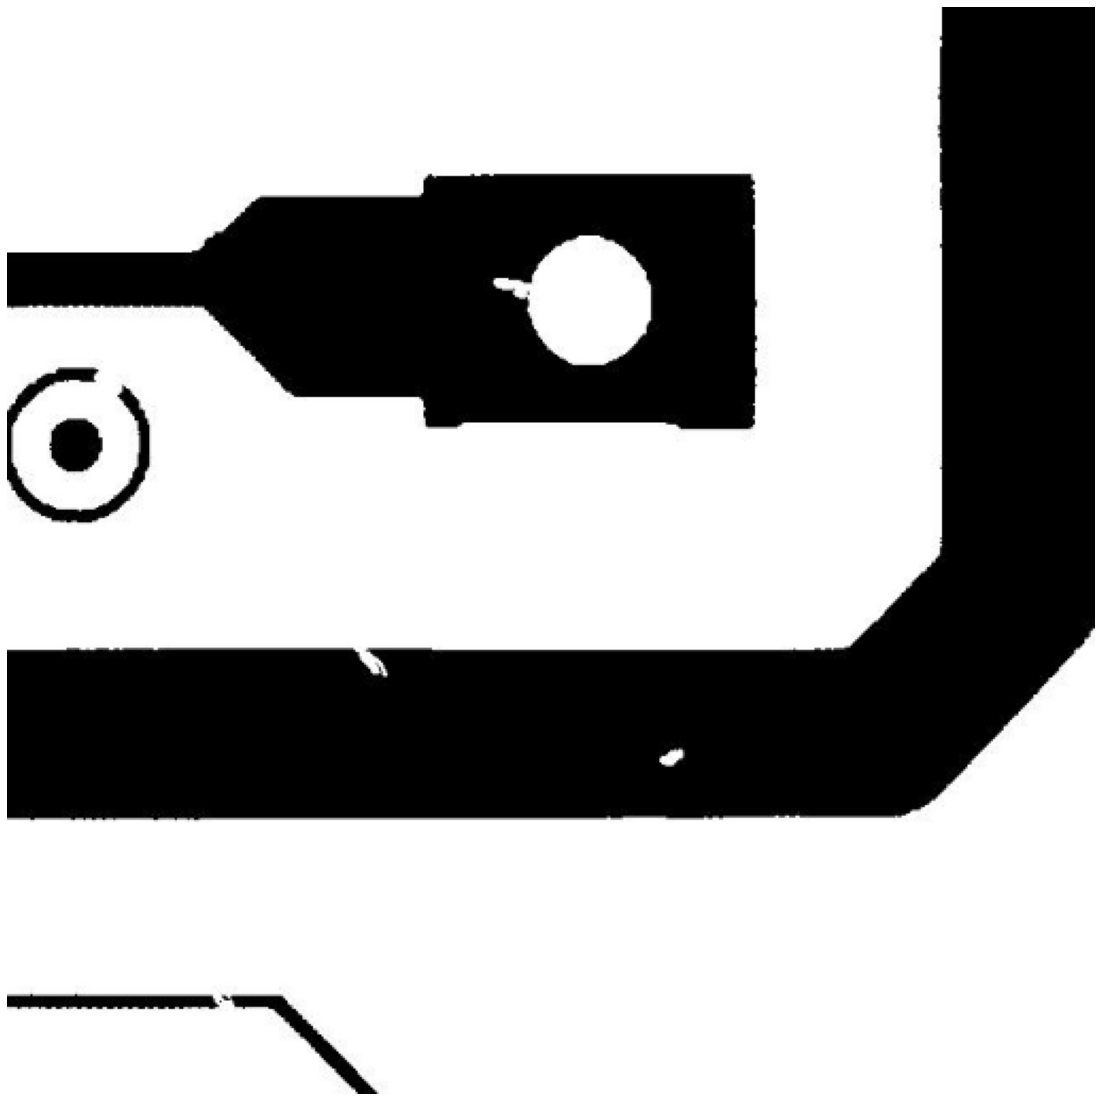

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


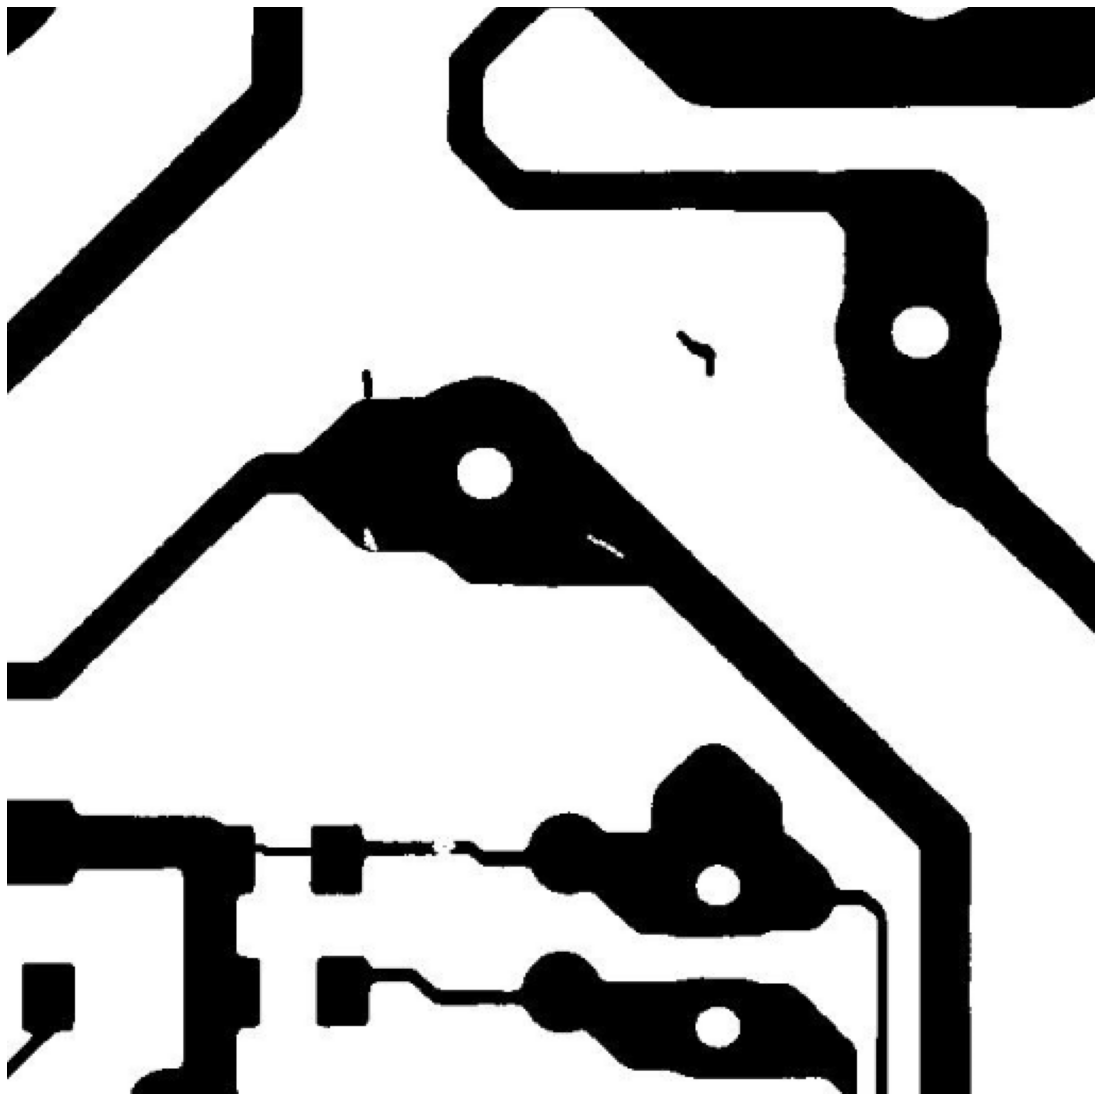

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


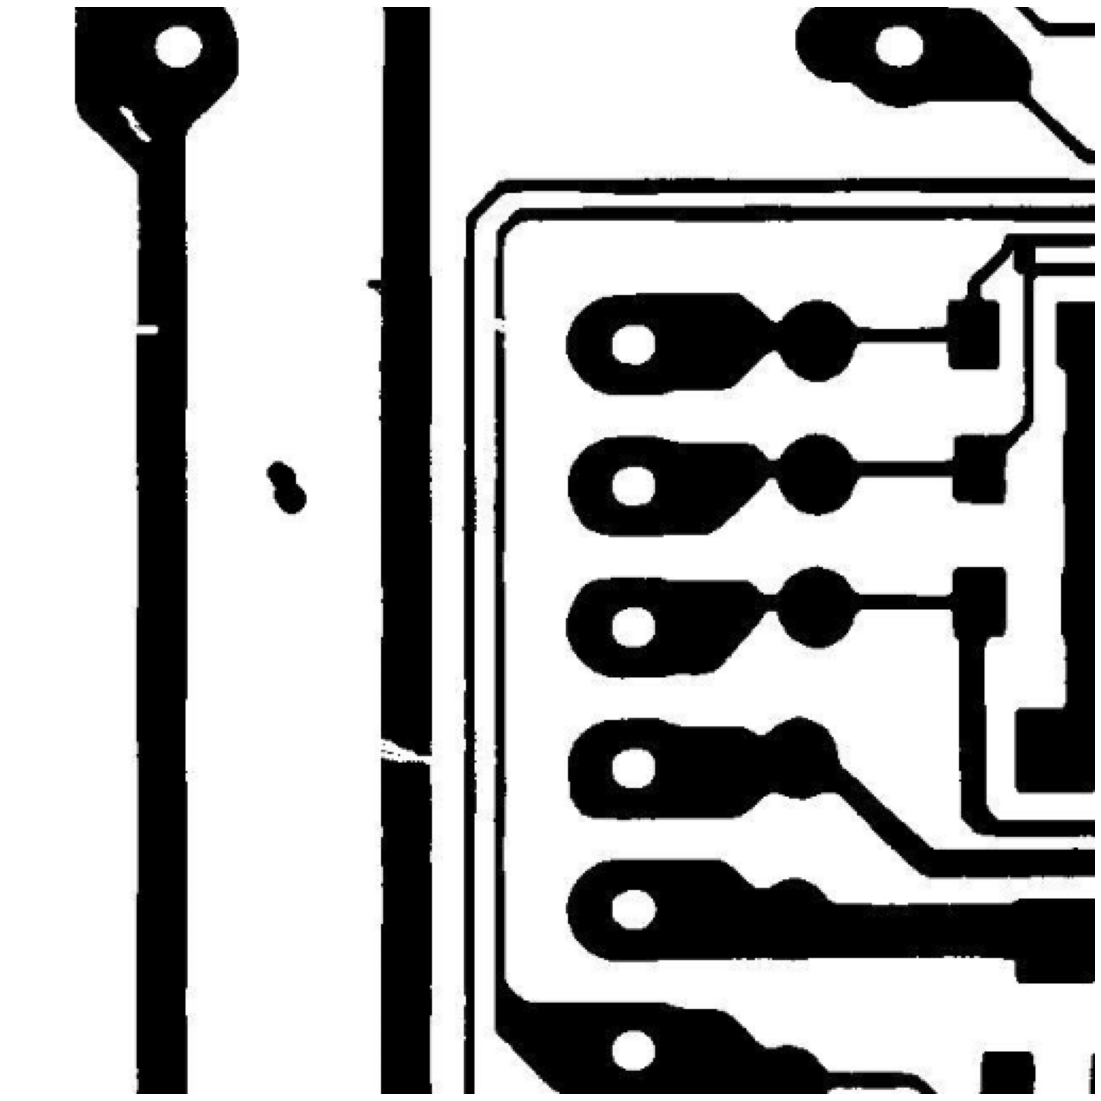

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


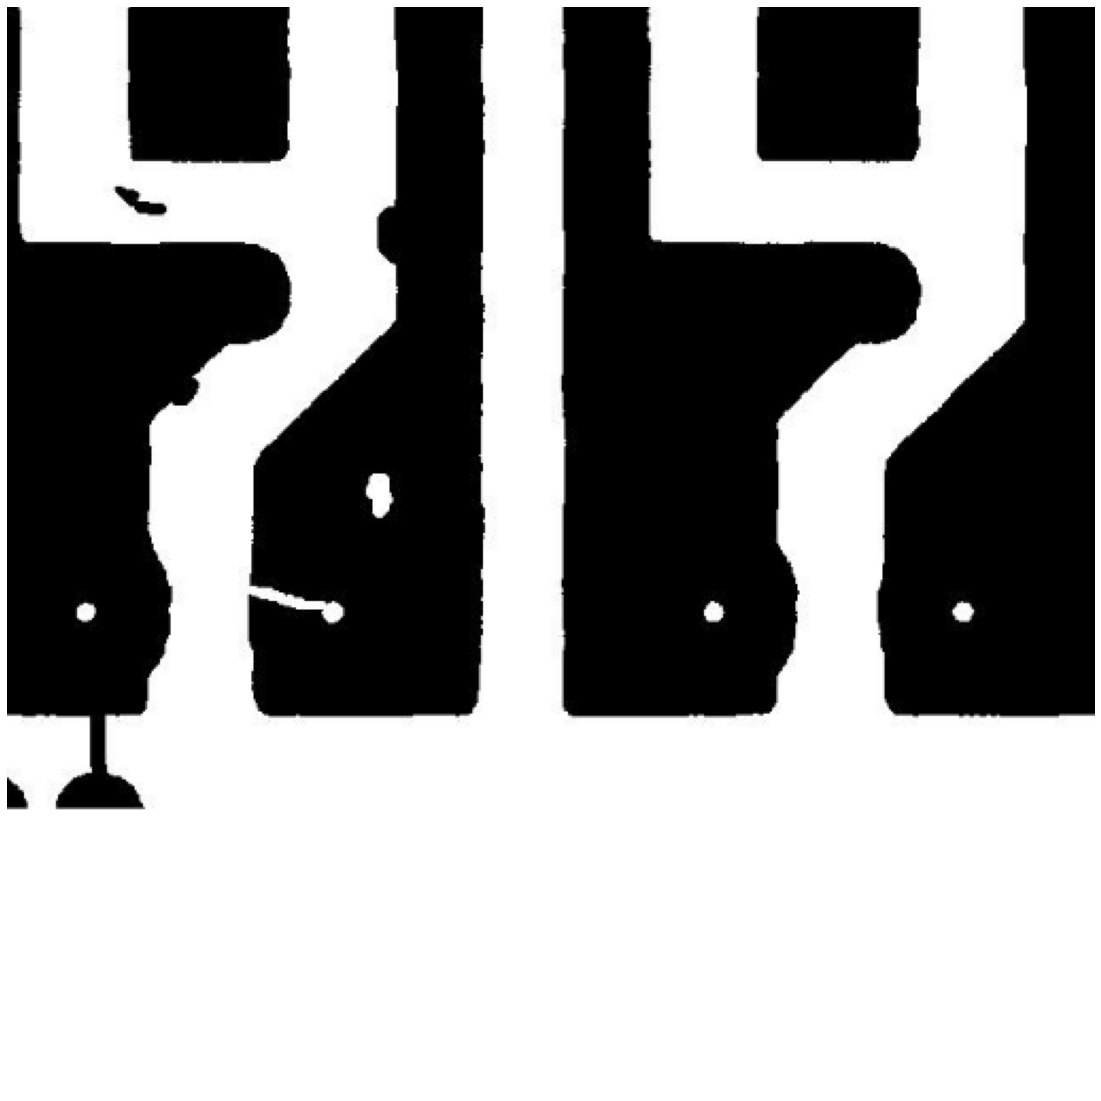

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


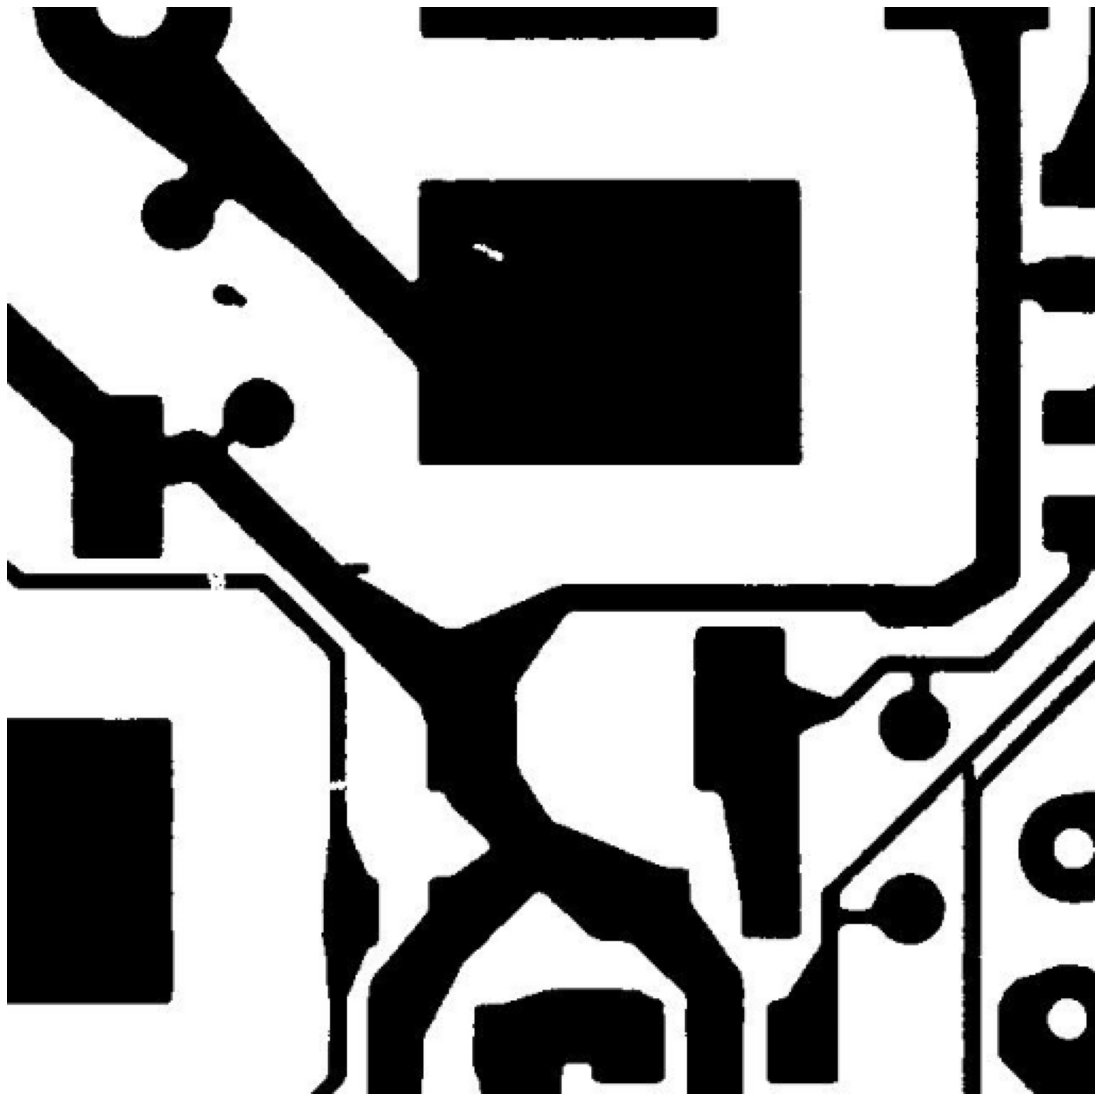

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


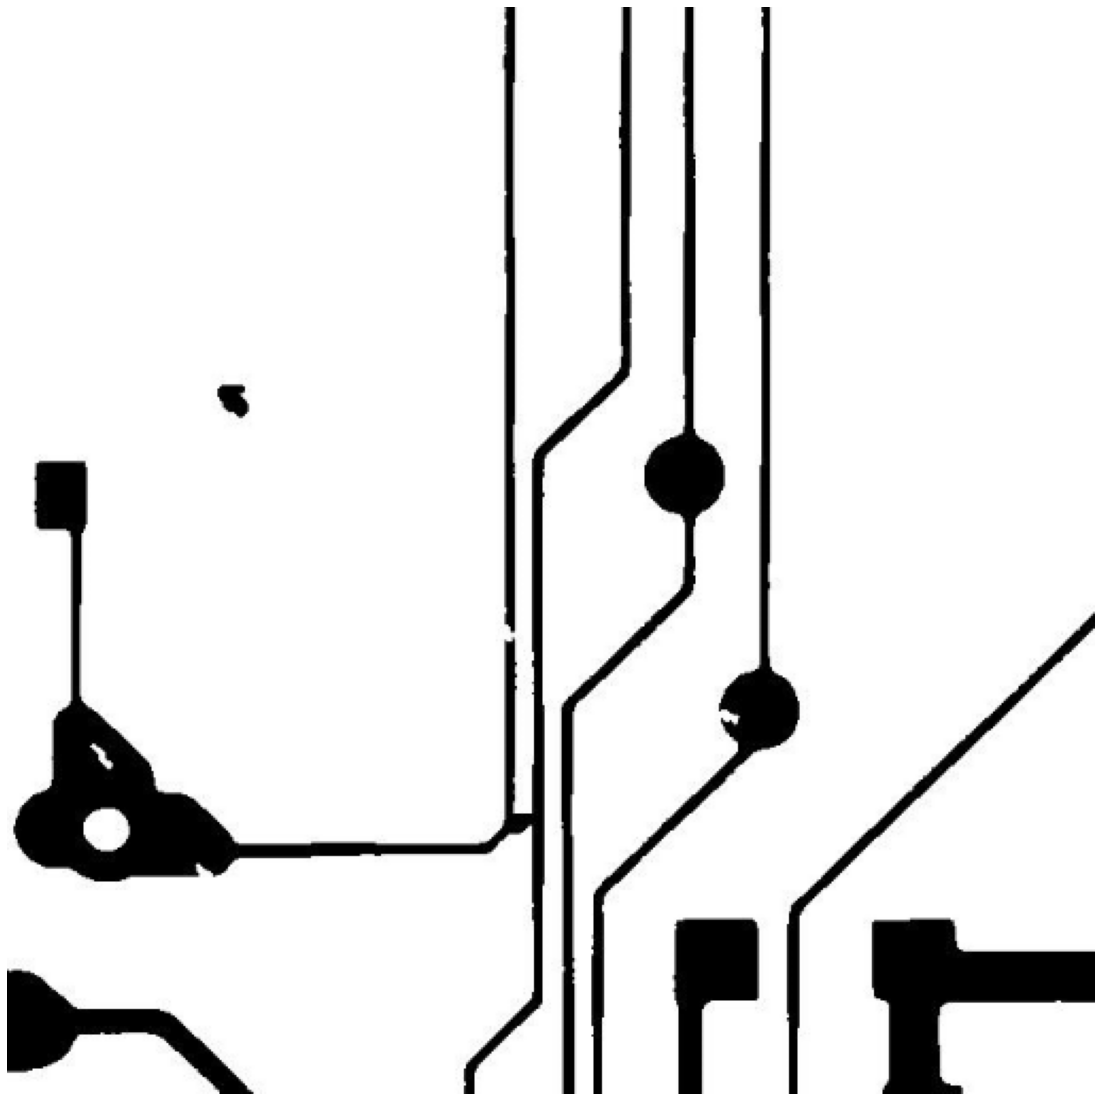

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


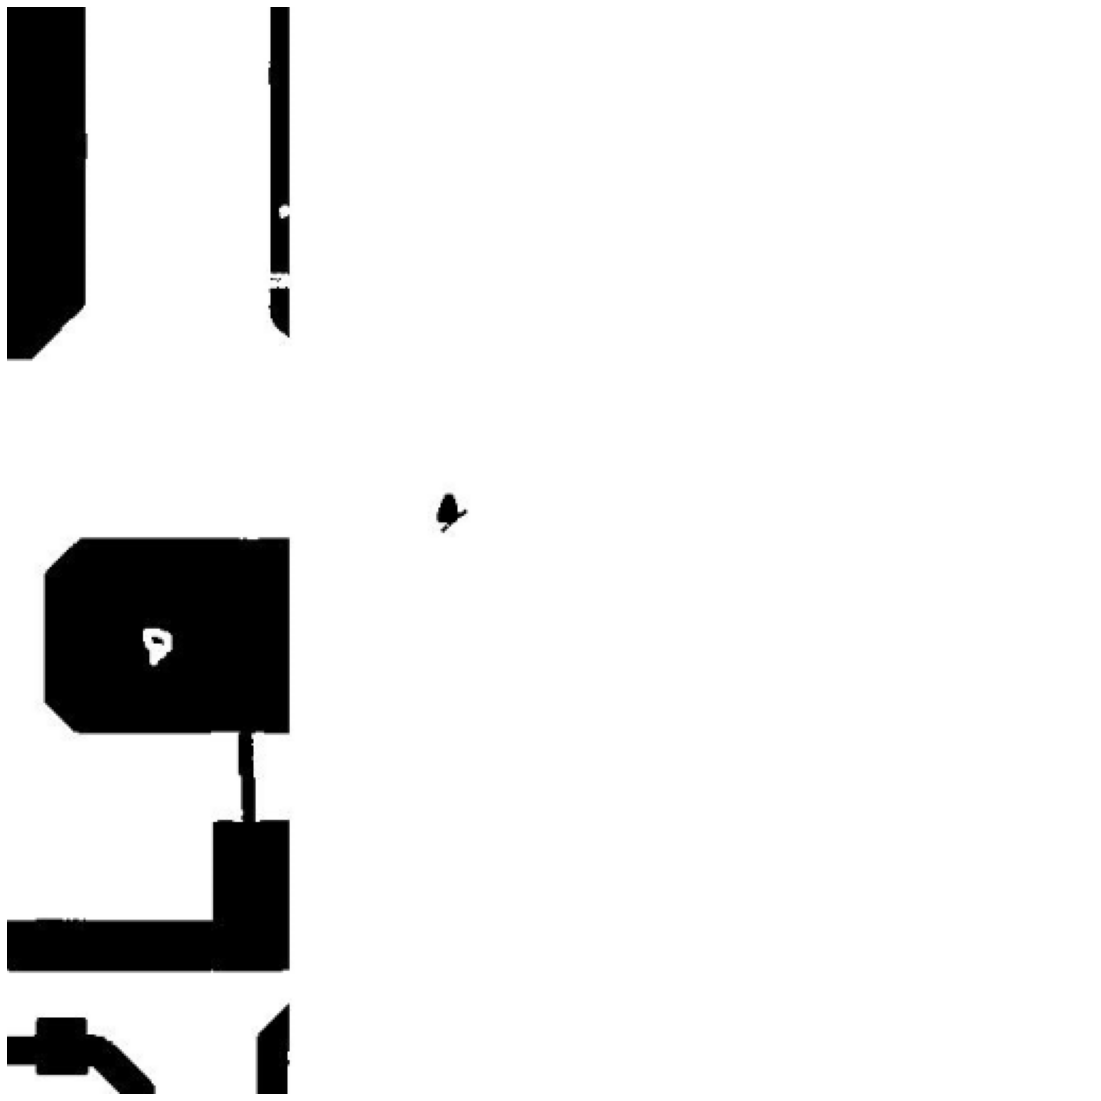

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


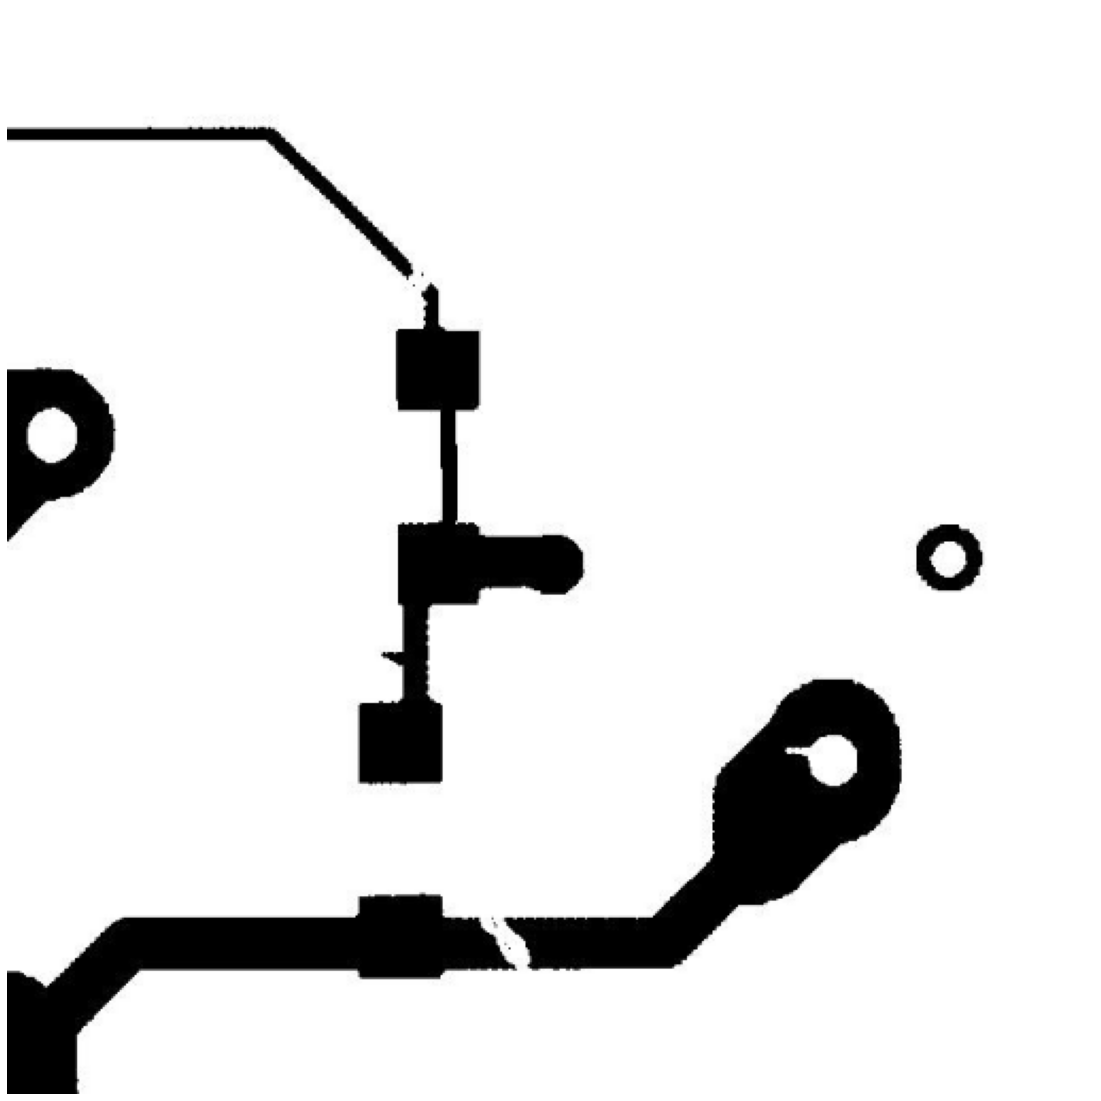

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


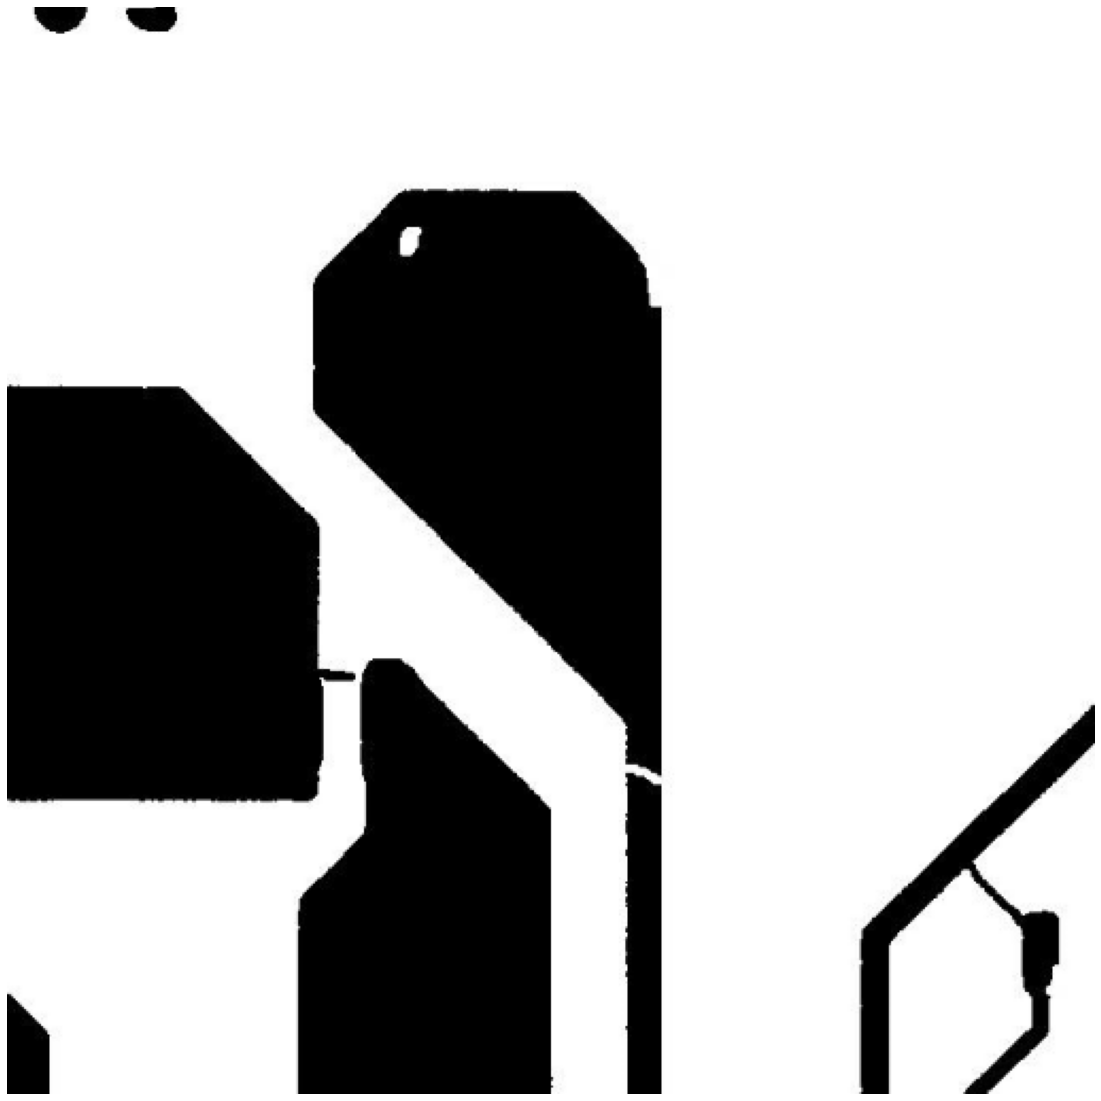

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


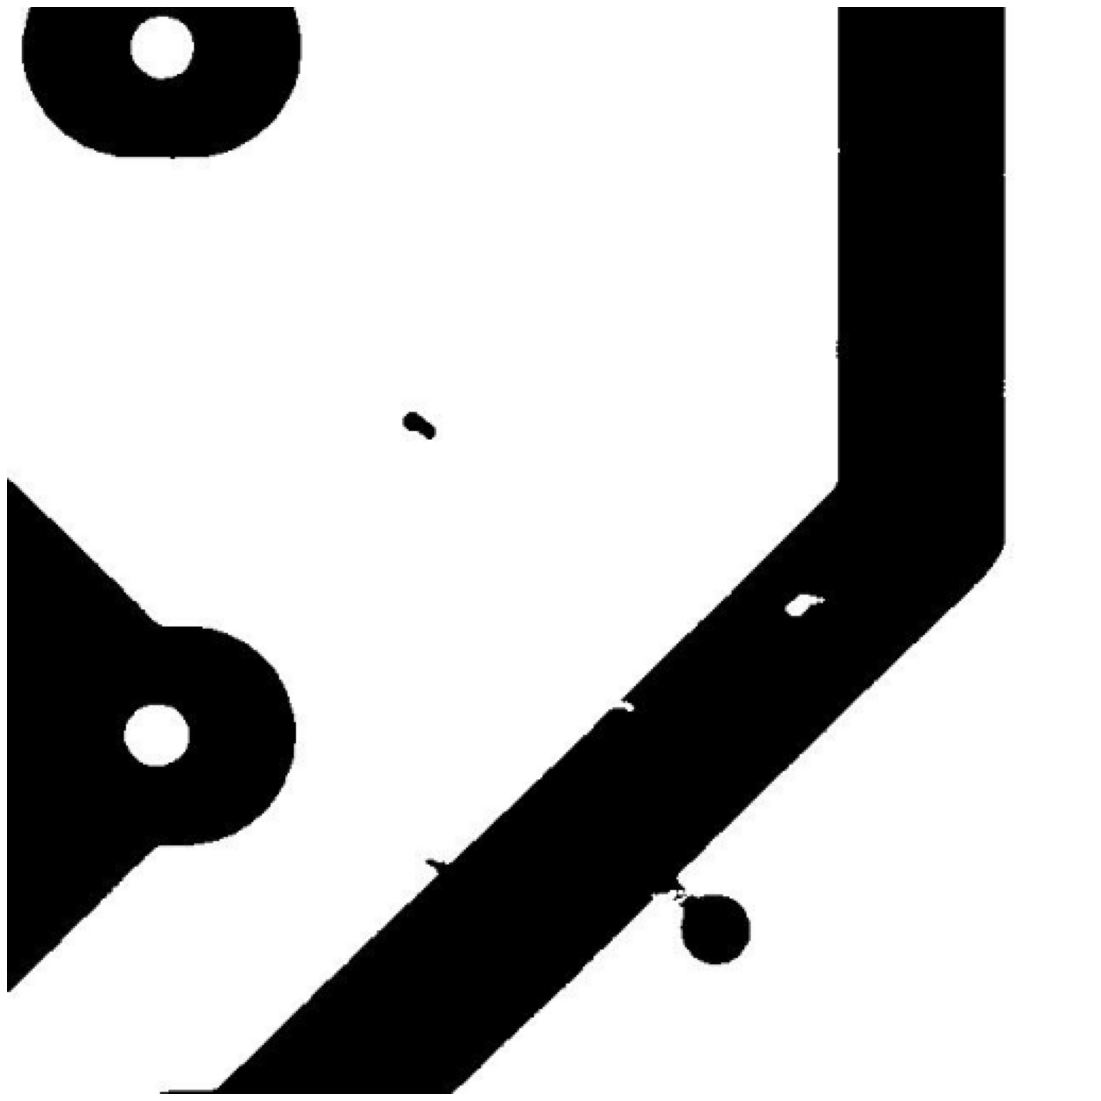

In [16]:
for d in random.sample(dataset_dicts, 10):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im,
                   metadata=PCB_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    print(outputs['instances'].pred_classes)
    print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("PCB_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "PCB_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

Streaming output truncated to the last 5000 lines.
['422', '443', '460', '472', '4']
[422.0, 443.0, 460.0, 472.0]
{'bbox': [422.0, 443.0, 460.0, 472.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}
['106', '283', '152', '314', '6']
[106.0, 283.0, 152.0, 314.0]
{'bbox': [106.0, 283.0, 152.0, 314.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}
['234', '429', '262', '461', '5']
[234.0, 429.0, 262.0, 461.0]
{'bbox': [234.0, 429.0, 262.0, 461.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}
['232', '238', '278', '278', '3']
[232.0, 238.0, 278.0, 278.0]
{'bbox': [232.0, 238.0, 278.0, 278.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}
./DeepPCB/PCBData/group12100/12100_not/12100019.txt
['178 280 211 310 1\n', '50 428 80 460 3\n', '12 261 47 312 2\n', '494 501 524 536 3\n', '215 565 244 602 4\n', '411 309 444 342 6\n', '183 516 219 541 3\n', '287 425 322 455 1\n']
['178', '280', '211', '310', '1']
[1

OrderedDict([('bbox',
              {'AP': 0.07452812271528823,
               'AP-copper': 0.432917276397016,
               'AP-mousebite': 0.0018715640197937784,
               'AP-open': 0.00396757489924669,
               'AP-pin-hole': 0.0073563194854309455,
               'AP-short': 0.0005578033207727708,
               'AP-spur': 0.0004981981694692566,
               'AP50': 0.37686950211317366,
               'AP75': 0.005270164584190862,
               'APl': 0.003354579000335459,
               'APm': 0.17126300127833777,
               'APs': 0.0015344284110218455})])